In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss, precision_score, precision_recall_curve
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import classification_report

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from timeit import default_timer as timer
from tqdm.notebook import tqdm


In [210]:
data = pd.read_csv("/data/work/wessex/Wessex/test/Brunel_track_seeds_with_target.csv")
target = data.particle_isDown_noVelo 
features = data.drop(["Unnamed: 0", 
                      "Unnamed: 0_x", # index
                      "Unnamed: 0_y",
                      "eventID",
                      "particle_key",
                      "particle_hasUT",
                      "particle_pid", # this are MC info
                      "particle_hasScifi",
                      "particle_isDown_noVelo",
                      "particle_isDown",
                      "particle_hasVelo",
                      "track_charge",
                      "track_position_z",
                     ], axis=1)
features.head()

,track_phi,track_tx,track_ty,track_nLHCbIDs,track_p,track_chi2,track_position_x,track_position_y,track_chi2PerDoF,track_pt,track_pseudoRapidity,track_position_r,track_position_phi
0,2.849378,-0.343474,0.103326,12.0,2020.072174,6.275086,494.515198,1124.644897,0.896441,682.012956,1.749189,7599.958646,1.156534
1,-3.082239,-0.358948,-0.021330,12.0,3841.771978,1.360128,-1080.491943,-141.657471,0.194304,1299.941130,1.746825,7578.755154,-3.011232
2,-0.011027,0.096606,-0.001065,11.0,11831.335600,1.228229,235.222702,-5.106698,0.204705,1137.754221,3.032522,7503.689479,-0.021707
3,3.105371,-0.442834,0.016047,9.0,1982.935289,1.397992,-256.822998,115.813004,0.349498,803.347165,1.552877,7505.289515,2.717953
4,-3.125277,-0.170356,-0.002780,11.0,6950.099982,1.731246,-439.475525,-42.887833,0.288541,1167.325690,2.470060,7512.987296,-3.044312


In [211]:
target

0          False
1          False
2          False
3          False
4          False
           ...  
6431432    False
6431433    False
6431434    False
6431435    False
6431436    False
Name: particle_isDown_noVelo, Length: 6431437, dtype: bool

In [219]:
target =  target.astype(int)

In [225]:
def create_sampler(target):
    class_sample_count = np.array(
        [len(np.where(target == t)[0]) for t in np.unique(target)])
    weight = 1. / class_sample_count
    samples_weight = np.array([weight[t] for t in target])
    samples_weight = torch.from_numpy(samples_weight)
    samples_weigth = samples_weight.double()
    return torch.utils.data.sampler.WeightedRandomSampler(samples_weight, len(samples_weight))




In [226]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [227]:
X_train, X_valid, Y_train, Y_valid = train_test_split(features, target, test_size=0.2, random_state=12)

In [228]:
X_valid = (X_valid - X_train.mean()) / X_train.std()
X_train = (X_train - X_train.mean()) / X_train.std()

In [229]:
datasets={
    "train":TensorDataset(torch.Tensor(np.array(X_train.values)).to(device), torch.Tensor(np.array(Y_train.values, dtype=np.uint8)).to(device)),
    "valid":TensorDataset(torch.Tensor(np.array(X_valid.values)).to(device), torch.Tensor(np.array(Y_valid.values, dtype=np.uint8)).to(device))
}


In [230]:
datasets["valid"].__getitem__(0)

(tensor([ 5.5752e-02,  6.0465e-01,  3.2267e-01,  7.1693e-01, -3.9098e-03,
         -5.5659e-01,  7.8569e-01,  2.9878e-01, -5.9557e-01, -3.3483e-04,
         -1.3694e-01, -3.9947e-01,  1.2029e-01], device='cuda:0'),
 tensor(0., device='cuda:0'))

In [231]:
dataloaders = { 
    'train':DataLoader(datasets["train"],
                   sampler=create_sampler(Y_train),
                   batch_size=128,
                   shuffle=False,
                    num_workers=0),
    'valid':DataLoader(datasets["valid"],
                      batch_size=128,
                      shuffle=False,
                      num_workers=0)
}

In [232]:
for batch in dataloaders["train"]:
    print("features", batch[0], len(batch[0]))
    print("target", batch[1], len(batch[1]))
    break

features tensor([[ 1.0330e-03,  1.2663e-01, -5.2506e-03,  ...,  1.4542e+00,
         -7.6270e-01,  2.2914e-02],
        [-2.2668e-01,  1.0831e+00, -2.7371e+00,  ..., -8.8094e-01,
          1.6608e+00, -5.4596e-01],
        [-2.0846e-01,  1.7663e-01, -4.6886e-01,  ...,  1.0306e+00,
         -7.4656e-01, -7.6060e-01],
        ...,
        [-1.5344e+00, -1.5827e+00, -1.6323e-01,  ..., -1.1089e+00,
          1.3096e-01, -1.5927e+00],
        [ 1.5149e-02,  2.0297e-01,  2.4969e-02,  ...,  1.0053e+00,
         -7.6538e-01, -3.5325e-02],
        [-1.2531e-02,  1.4379e+00, -2.4544e-01,  ..., -1.0551e+00,
          6.7910e-02, -6.7365e-02]], device='cuda:0') 128
target tensor([0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 1.,
        0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1.,
        0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
        1., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0.,
        1.,

In [233]:
def train_and_valid_classification(model,
                                   criterion,
                                   optimizer,
                                   run_hist={},
                                   num_epochs=10,
                                   save_every_nth_batch_loss=50):
    """Train and evaluate the classification model."""
    if len(run_hist) == 0:
        run_hist = {key: [] for key in ['epoch_loss_train',
                                    'epoch_loss_valid',
                                    'epoch_acc_valid',
                                    'epoch_acc_train',   
                                    'batch_loss_train']}
    process_timer = timer()
    
    for epoch in range(num_epochs):
        print('\nEpoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'valid']:
            start_epoch = timer()
            if phase == 'train':
                model.train()
            else:
                model.eval()
        
            running_loss = 0.0
            running_corrects = 0
            
            batch_iterator = tqdm(iter(dataloaders[phase]), leave=False, total=len(dataloaders[phase]))

        
            for i, batch in enumerate(batch_iterator):
                inputs, labels = batch
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels.long())

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.detach() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data.long())

                if phase == 'train' and i % save_every_nth_batch_loss == 0:
                    run_hist['batch_loss_train'].append(loss.item())

            epoch_loss = running_loss / len(datasets[phase])
            epoch_acc = running_corrects.float() / len(datasets[phase])

            print('{} loss: {:.4f}, {} acc: {:.4f}, elapsed:{:.4f}'.\
            format(phase,
                   epoch_loss.item(),
                   phase,
                   epoch_acc.item(),
                   timer()-start_epoch
                 ))
                 
        
            run_hist['epoch_loss_' + phase].append(epoch_loss.item())
            run_hist['epoch_acc_' + phase].append(epoch_acc.item())

    print("training took: ",timer()- process_timer)    
    return model, run_hist

# Build the shallow model

In [234]:
class NHiddenTrackingNetwork(torch.nn.Module):
    def __init__(self, inputs,n_hidden, hidden_dict):
        super(NHiddenTrackingNetwork, self).__init__()
        if n_hidden < 3: 
          raise ValueError("n_hidden must be greater than 2")
        self.input_layer = nn.Linear(inputs, hidden_dict[0])
        self.layers = nn.ModuleList()
        for layer_it in range(n_hidden-1):
          self.layers.append(nn.Linear(hidden_dict[layer_it],
                                       hidden_dict[layer_it+1]))
        self.output_layer = nn.Linear(hidden_dict[n_hidden-1], 2) 
        # initialize layers
        self.layers.apply(self._init_weights)
        self._init_weights(self.output_layer)
                
        
    def forward(self, x):
        x = self.input_layer(x)
        x = F.relu(x)
        for layer in self.layers:
          x = layer(x)
          x = F.relu(x)
        x = self.output_layer(x)
        return x
    
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)
            m.bias.data.fill_(0.01)




In [235]:
n_hidden = {0:40,
            1:30,
           2:20,
           3:10}

model = NHiddenTrackingNetwork(X_train.shape[1], 4, n_hidden).to(device)
model

NHiddenTrackingNetwork(
  (input_layer): Linear(in_features=13, out_features=40, bias=True)
  (layers): ModuleList(
    (0): Linear(in_features=40, out_features=30, bias=True)
    (1): Linear(in_features=30, out_features=20, bias=True)
    (2): Linear(in_features=20, out_features=10, bias=True)
  )
  (output_layer): Linear(in_features=10, out_features=2, bias=True)
)

In [236]:
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())


Model's state_dict:
input_layer.weight 	 torch.Size([40, 13])
input_layer.bias 	 torch.Size([40])
layers.0.weight 	 torch.Size([30, 40])
layers.0.bias 	 torch.Size([30])
layers.1.weight 	 torch.Size([20, 30])
layers.1.bias 	 torch.Size([20])
layers.2.weight 	 torch.Size([10, 20])
layers.2.bias 	 torch.Size([10])
output_layer.weight 	 torch.Size([2, 10])
output_layer.bias 	 torch.Size([2])


In [64]:
1- sum(target)/len(target)

0.8552497676646759

In [65]:
1- sum(Y_train)/len(Y_train)

0.855171929909124

In [66]:
1- sum(Y_valid)/len(Y_valid)

0.8555611185053424

In [237]:
criterion = nn.CrossEntropyLoss().cuda()
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [238]:
model, run_hist = train_and_valid_classification(model, criterion, optimizer, num_epochs=10)


Epoch 1/10
----------


train loss: 0.6388, train acc: 0.6323, elapsed:157.6476


valid loss: 0.6264, valid acc: 0.6187, elapsed:17.6634

Epoch 2/10
----------


train loss: 0.6040, train acc: 0.6642, elapsed:160.0908


valid loss: 0.6011, valid acc: 0.6538, elapsed:17.6422

Epoch 3/10
----------


train loss: 0.5898, train acc: 0.6724, elapsed:155.4188


valid loss: 0.6143, valid acc: 0.6424, elapsed:17.4915

Epoch 4/10
----------


train loss: 0.5814, train acc: 0.6777, elapsed:156.3532


valid loss: 0.5979, valid acc: 0.6562, elapsed:17.4621

Epoch 5/10
----------


train loss: 0.5763, train acc: 0.6809, elapsed:155.7328


valid loss: 0.5655, valid acc: 0.6954, elapsed:17.5845

Epoch 6/10
----------


train loss: 0.5736, train acc: 0.6826, elapsed:157.0929


valid loss: 0.5856, valid acc: 0.6712, elapsed:17.5651

Epoch 7/10
----------


train loss: 0.5719, train acc: 0.6840, elapsed:154.6162


valid loss: 0.5809, valid acc: 0.6772, elapsed:17.8722

Epoch 8/10
----------


train loss: 0.5707, train acc: 0.6851, elapsed:158.9507


valid loss: 0.5778, valid acc: 0.6744, elapsed:17.4764

Epoch 9/10
----------


train loss: 0.5696, train acc: 0.6857, elapsed:156.7937


valid loss: 0.5667, valid acc: 0.6951, elapsed:17.3716

Epoch 10/10
----------


train loss: 0.5685, train acc: 0.6866, elapsed:155.2071


valid loss: 0.5686, valid acc: 0.6935, elapsed:17.2453
training took:  1743.2827578759752


In [239]:
def print_roc(model, X, Y):
    X = torch.tensor(X.values, dtype=torch.float).to("cpu")
    model.eval
    model.to("cpu")
    output =  model(X)    
    plt.figure(figsize=[6, 6])
    pred = F.softmax(output, dim=1).cpu().detach().numpy()[:,1]
    fpr, tpr, thresholds = roc_curve(Y,pred )
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label='ROC BDT (area = %0.4f)'%(roc_auc))
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='no discrimination')
    plt.xlim([-0.05, 1.05])
    plt.ylim([0.8, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()
    del X



In [240]:
def plot_training_classification(run_hist):
    """Plot the training history of the classification model."""
    fig, ax = plt.subplots(1,2, figsize=(20,6), sharex=True)
    x = np.arange(len(run_hist["epoch_loss_train"])) + 1
    ax[0].plot(x, run_hist["epoch_loss_train"],'b', marker='.', label="train loss")
    ax[0].plot(x, run_hist["epoch_loss_valid"],'r', marker='.', label="valid loss")
    ax[0].legend()
    ax[1].plot(x, run_hist["epoch_acc_train"],'b', marker='.', label="train accuracy")
    ax[1].plot(x, run_hist["epoch_acc_valid"],'r', marker='.', label="valid accuracy")
    ax[1].legend()


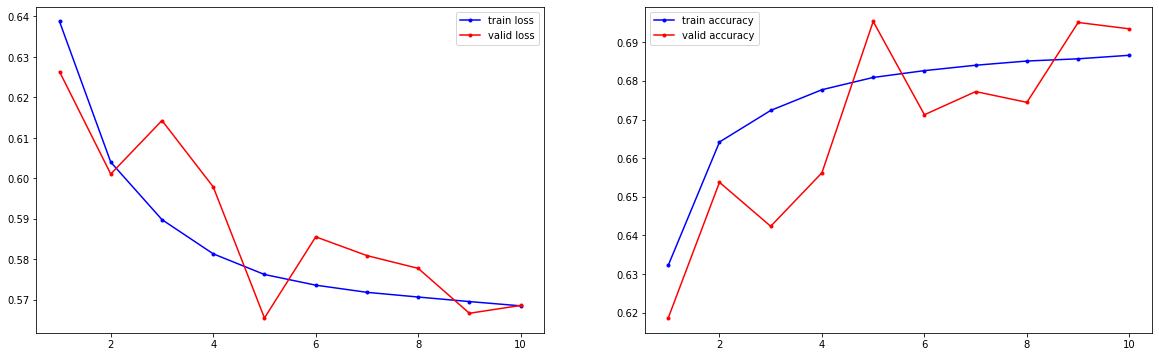

In [241]:
plot_training_classification(run_hist)

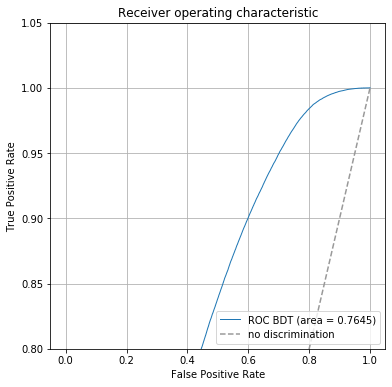

In [242]:
print_roc(model,X_valid, Y_valid )

In [243]:
for param in model.named_parameters():
  print(param)


('input_layer.weight', Parameter containing:
tensor([[-2.1678e-01, -1.8300e-01,  3.9787e-01, -3.8210e-02,  2.9885e-01,
          1.1089e-01,  2.5829e-01,  3.8043e-01, -1.0578e-01, -1.1624e+00,
         -1.3596e-01, -8.9366e-03, -1.2414e-01],
        [ 3.8910e-02, -4.6832e-01,  1.3174e-04, -2.6043e-04, -3.0280e-01,
         -4.7216e-03,  5.1375e-01,  1.2744e-02,  3.7833e-03,  2.6545e-02,
          1.3457e-02,  3.0392e-02, -4.1950e-02],
        [-2.7658e-01,  3.6508e-01,  3.2715e-01,  1.9576e-02, -6.9636e-01,
         -9.9735e-02, -1.9277e-01, -3.8028e-01,  1.0100e-01, -1.2258e+00,
         -9.0516e-02,  9.4528e-02, -2.2495e-01],
        [ 1.1549e-01, -8.3609e-03,  2.9422e-01,  1.5940e-03, -3.4693e-01,
          5.6437e-02, -1.2215e-01, -3.3597e-02, -6.3920e-02, -1.4121e+00,
          4.5536e-02,  7.8831e-02,  1.4491e-01],
        [-2.0908e-01, -1.8924e-01, -4.8148e-01,  5.3928e-03,  2.1040e-01,
          1.8666e-02,  1.0935e-01, -5.9276e-03, -2.9193e-02, -1.1342e+00,
         -3.4327e-0

In [244]:
trenable_parameters = filter(lambda p: p.requires_grad, model.parameters())
print("n_params", sum([np.prod(p.size()) for p in trenable_parameters]) )

n_params 2642


In [245]:
torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'run_history':run_hist,
            }, ".4NN.pt")


In [246]:
model.to(device)

NHiddenTrackingNetwork(
  (input_layer): Linear(in_features=13, out_features=40, bias=True)
  (layers): ModuleList(
    (0): Linear(in_features=40, out_features=30, bias=True)
    (1): Linear(in_features=30, out_features=20, bias=True)
    (2): Linear(in_features=20, out_features=10, bias=True)
  )
  (output_layer): Linear(in_features=10, out_features=2, bias=True)
)

In [247]:
model, run_hist = train_and_valid_classification(model, criterion, optimizer,run_hist, num_epochs=20)


Epoch 1/20
----------


train loss: 0.5681, train acc: 0.6868, elapsed:159.0224


valid loss: 0.5592, valid acc: 0.7036, elapsed:17.6148

Epoch 2/20
----------


train loss: 0.5676, train acc: 0.6874, elapsed:153.7366


valid loss: 0.5738, valid acc: 0.6848, elapsed:17.6309

Epoch 3/20
----------


train loss: 0.5669, train acc: 0.6877, elapsed:157.0809


valid loss: 0.5517, valid acc: 0.7143, elapsed:19.1420

Epoch 4/20
----------


train loss: 0.5666, train acc: 0.6881, elapsed:155.3510


valid loss: 0.5641, valid acc: 0.6976, elapsed:19.6809

Epoch 5/20
----------


train loss: 0.5659, train acc: 0.6883, elapsed:158.6134


valid loss: 0.5672, valid acc: 0.6905, elapsed:17.5667

Epoch 6/20
----------


train loss: 0.5657, train acc: 0.6885, elapsed:157.8483


valid loss: 0.5707, valid acc: 0.6906, elapsed:17.4830

Epoch 7/20
----------


train loss: 0.5654, train acc: 0.6891, elapsed:156.9042


valid loss: 0.5659, valid acc: 0.6914, elapsed:17.6326

Epoch 8/20
----------


train loss: 0.5648, train acc: 0.6892, elapsed:156.6877


valid loss: 0.5698, valid acc: 0.6874, elapsed:17.7060

Epoch 9/20
----------


train loss: 0.5648, train acc: 0.6893, elapsed:158.6965


valid loss: 0.5526, valid acc: 0.7057, elapsed:17.7265

Epoch 10/20
----------


train loss: 0.5643, train acc: 0.6898, elapsed:160.5694


valid loss: 0.5789, valid acc: 0.6788, elapsed:17.6730

Epoch 11/20
----------


train loss: 0.5645, train acc: 0.6893, elapsed:155.1620


valid loss: 0.5569, valid acc: 0.7023, elapsed:17.4336

Epoch 12/20
----------


train loss: 0.5639, train acc: 0.6903, elapsed:156.6860


valid loss: 0.5757, valid acc: 0.6829, elapsed:17.6667

Epoch 13/20
----------


train loss: 0.5635, train acc: 0.6902, elapsed:159.2103


valid loss: 0.5814, valid acc: 0.6799, elapsed:17.7625

Epoch 14/20
----------


train loss: 0.5634, train acc: 0.6905, elapsed:160.5766


valid loss: 0.5747, valid acc: 0.6820, elapsed:17.7206

Epoch 15/20
----------


train loss: 0.5635, train acc: 0.6903, elapsed:159.4167


valid loss: 0.5720, valid acc: 0.6881, elapsed:17.7755

Epoch 16/20
----------


train loss: 0.5631, train acc: 0.6908, elapsed:154.9500


valid loss: 0.5709, valid acc: 0.6847, elapsed:17.6330

Epoch 17/20
----------


train loss: 0.5635, train acc: 0.6903, elapsed:157.8587


valid loss: 0.5798, valid acc: 0.6791, elapsed:17.4307

Epoch 18/20
----------


train loss: 0.5631, train acc: 0.6906, elapsed:157.6984


valid loss: 0.5720, valid acc: 0.6884, elapsed:17.4685

Epoch 19/20
----------


train loss: 0.5629, train acc: 0.6908, elapsed:157.7817


valid loss: 0.5819, valid acc: 0.6809, elapsed:17.6733

Epoch 20/20
----------


train loss: 0.5627, train acc: 0.6912, elapsed:157.5637


valid loss: 0.5799, valid acc: 0.6775, elapsed:17.4580
training took:  3507.310215326026


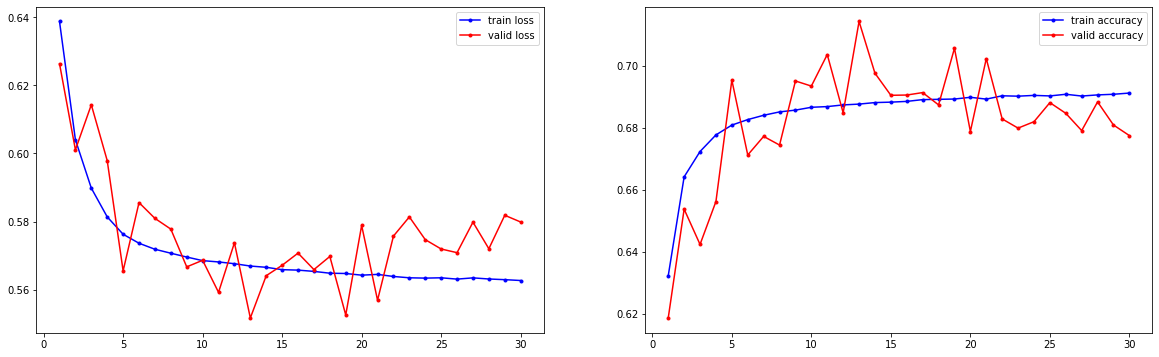

In [248]:
plot_training_classification(run_hist)

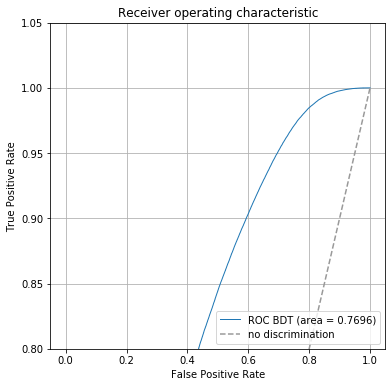

In [249]:
print_roc(model,X_valid, Y_valid )

In [259]:
print_classification_report(model,X_valid, Y_valid, 0.20)

              precision    recall  f1-score   support

       ghost       0.99      0.21      0.35   1100498
        true       0.17      0.98      0.29    185790

   micro avg       0.32      0.32      0.32   1286288
   macro avg       0.58      0.60      0.32   1286288
weighted avg       0.87      0.32      0.34   1286288



In [260]:
model.to(device)

NHiddenTrackingNetwork(
  (input_layer): Linear(in_features=13, out_features=40, bias=True)
  (layers): ModuleList(
    (0): Linear(in_features=40, out_features=30, bias=True)
    (1): Linear(in_features=30, out_features=20, bias=True)
    (2): Linear(in_features=20, out_features=10, bias=True)
  )
  (output_layer): Linear(in_features=10, out_features=2, bias=True)
)

In [261]:
model, run_hist = train_and_valid_classification(model, criterion, optimizer,run_hist, num_epochs=10)


Epoch 1/10
----------


train loss: 0.5627, train acc: 0.6910, elapsed:158.1074


valid loss: 0.5467, valid acc: 0.7099, elapsed:19.9237

Epoch 2/10
----------


train loss: 0.5627, train acc: 0.6910, elapsed:157.1958


valid loss: 0.5628, valid acc: 0.6963, elapsed:17.5808

Epoch 3/10
----------


train loss: 0.5624, train acc: 0.6916, elapsed:156.7979


valid loss: 0.5717, valid acc: 0.6877, elapsed:17.5340

Epoch 4/10
----------


train loss: 0.5625, train acc: 0.6913, elapsed:157.4088


valid loss: 0.5461, valid acc: 0.7129, elapsed:17.7015

Epoch 5/10
----------


train loss: 0.5620, train acc: 0.6916, elapsed:156.9812


valid loss: 0.5712, valid acc: 0.6896, elapsed:17.6712

Epoch 6/10
----------


train loss: 0.5617, train acc: 0.6920, elapsed:155.3630


valid loss: 0.5698, valid acc: 0.6872, elapsed:17.6333

Epoch 7/10
----------


train loss: 0.5618, train acc: 0.6920, elapsed:155.9501


valid loss: 0.5751, valid acc: 0.6869, elapsed:17.5829

Epoch 8/10
----------


train loss: 0.5618, train acc: 0.6915, elapsed:157.4842


valid loss: 0.5566, valid acc: 0.7051, elapsed:17.3927

Epoch 9/10
----------


train loss: 0.5617, train acc: 0.6921, elapsed:158.9790


valid loss: 0.5712, valid acc: 0.6897, elapsed:18.5339

Epoch 10/10
----------


train loss: 0.5616, train acc: 0.6918, elapsed:155.8535


valid loss: 0.5624, valid acc: 0.6956, elapsed:17.6580
training took:  1749.337786336895


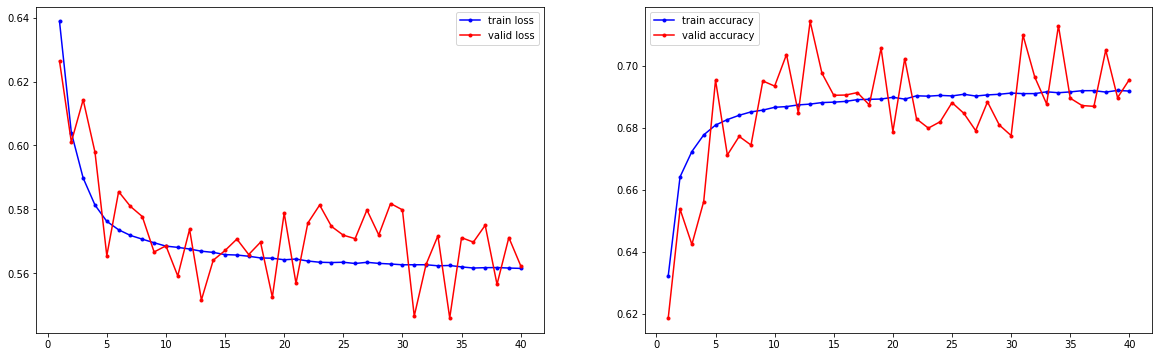

In [271]:
plot_training_classification(run_hist)

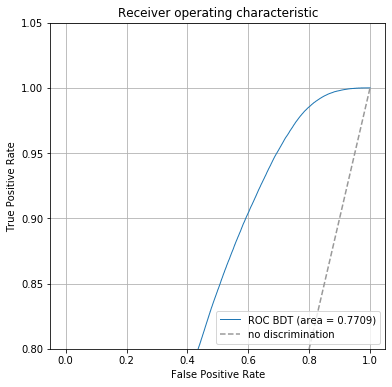

In [272]:
print_roc(model,X_valid, Y_valid )

In [273]:
print_classification_report(model,X_valid, Y_valid, 0.28)

              precision    recall  f1-score   support

       ghost       0.97      0.30      0.46   1100498
        true       0.19      0.95      0.31    185790

   micro avg       0.39      0.39      0.39   1286288
   macro avg       0.58      0.63      0.38   1286288
weighted avg       0.86      0.39      0.43   1286288



In [274]:
torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'run_history':run_hist,
            }, ".4NN_2.pt")


In [275]:
model.to(device)

NHiddenTrackingNetwork(
  (input_layer): Linear(in_features=13, out_features=40, bias=True)
  (layers): ModuleList(
    (0): Linear(in_features=40, out_features=30, bias=True)
    (1): Linear(in_features=30, out_features=20, bias=True)
    (2): Linear(in_features=20, out_features=10, bias=True)
  )
  (output_layer): Linear(in_features=10, out_features=2, bias=True)
)

In [276]:
model, run_hist = train_and_valid_classification(model, criterion, optimizer, run_hist, num_epochs=20)


Epoch 1/20
----------


train loss: 0.5618, train acc: 0.6917, elapsed:154.5194


valid loss: 0.5997, valid acc: 0.6590, elapsed:17.4986

Epoch 2/20
----------


train loss: 0.5616, train acc: 0.6918, elapsed:155.6353


valid loss: 0.5609, valid acc: 0.6994, elapsed:18.8038

Epoch 3/20
----------


train loss: 0.5616, train acc: 0.6920, elapsed:157.5776


valid loss: 0.5749, valid acc: 0.6823, elapsed:17.4147

Epoch 4/20
----------


train loss: 0.5615, train acc: 0.6918, elapsed:161.4499


valid loss: 0.5560, valid acc: 0.7063, elapsed:19.9721

Epoch 5/20
----------


train loss: 0.5612, train acc: 0.6923, elapsed:154.9093


valid loss: 0.5715, valid acc: 0.6846, elapsed:17.7132

Epoch 6/20
----------


train loss: 0.5612, train acc: 0.6924, elapsed:156.3136


valid loss: 0.5730, valid acc: 0.6878, elapsed:17.5853

Epoch 7/20
----------


train loss: 0.5612, train acc: 0.6920, elapsed:163.1484


valid loss: 0.5859, valid acc: 0.6739, elapsed:19.4925

Epoch 8/20
----------


train loss: 0.5612, train acc: 0.6923, elapsed:156.5148


valid loss: 0.5521, valid acc: 0.7058, elapsed:17.2812

Epoch 9/20
----------


train loss: 0.5612, train acc: 0.6923, elapsed:156.9652


valid loss: 0.5532, valid acc: 0.7097, elapsed:17.6245

Epoch 10/20
----------


train loss: 0.5610, train acc: 0.6923, elapsed:155.1658


valid loss: 0.5799, valid acc: 0.6768, elapsed:17.7229

Epoch 11/20
----------


train loss: 0.5610, train acc: 0.6922, elapsed:158.5414


valid loss: 0.5646, valid acc: 0.6946, elapsed:17.5929

Epoch 12/20
----------


train loss: 0.5609, train acc: 0.6926, elapsed:156.9727


valid loss: 0.5678, valid acc: 0.6889, elapsed:17.7200

Epoch 13/20
----------


train loss: 0.5607, train acc: 0.6928, elapsed:157.7394


valid loss: 0.5595, valid acc: 0.7010, elapsed:17.5338

Epoch 14/20
----------


train loss: 0.5606, train acc: 0.6926, elapsed:158.4907


valid loss: 0.5469, valid acc: 0.7151, elapsed:17.4480

Epoch 15/20
----------


train loss: 0.5607, train acc: 0.6927, elapsed:155.5353


valid loss: 0.5760, valid acc: 0.6792, elapsed:17.6168

Epoch 16/20
----------


train loss: 0.5607, train acc: 0.6930, elapsed:156.6264


valid loss: 0.5598, valid acc: 0.7024, elapsed:17.4969

Epoch 17/20
----------


train loss: 0.5605, train acc: 0.6928, elapsed:158.7126


valid loss: 0.5538, valid acc: 0.7086, elapsed:17.6065

Epoch 18/20
----------


train loss: 0.5606, train acc: 0.6928, elapsed:156.8481


valid loss: 0.5528, valid acc: 0.7101, elapsed:17.4199

Epoch 19/20
----------


train loss: 0.5603, train acc: 0.6930, elapsed:159.6533


valid loss: 0.5699, valid acc: 0.6850, elapsed:17.9868

Epoch 20/20
----------


train loss: 0.5602, train acc: 0.6931, elapsed:154.5378


valid loss: 0.5604, valid acc: 0.7003, elapsed:17.6895
training took:  3503.0875212838873


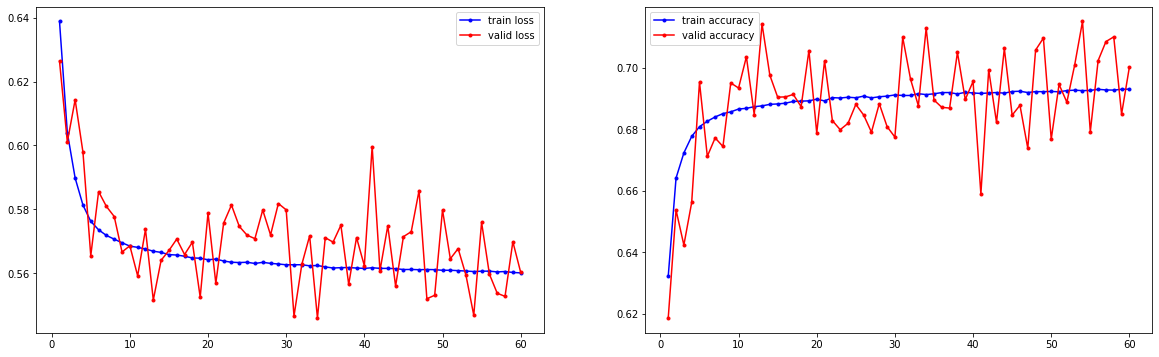

In [277]:
plot_training_classification(run_hist)

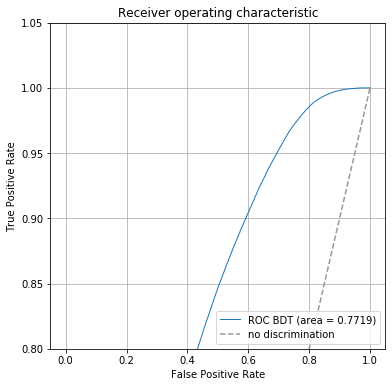

In [280]:
print_roc(model,X_valid, Y_valid )

In [284]:
torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'run_history':run_hist,
            }, ".4NN_3.pt")

In [283]:
model.to(device)

NHiddenTrackingNetwork(
  (input_layer): Linear(in_features=13, out_features=40, bias=True)
  (layers): ModuleList(
    (0): Linear(in_features=40, out_features=30, bias=True)
    (1): Linear(in_features=30, out_features=20, bias=True)
    (2): Linear(in_features=20, out_features=10, bias=True)
  )
  (output_layer): Linear(in_features=10, out_features=2, bias=True)
)

In [285]:
learning_rate = 1e-5
optimizer_2 = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [178]:
checkpoint = torch.load(".4NN_3.pt")
# to create checkpoint
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
run_hist = checkpoint["run_history"]

In [286]:
model, run_hist = train_and_valid_classification(model, criterion, optimizer_2, run_hist, num_epochs=50)


Epoch 1/50
----------


train loss: 0.5584, train acc: 0.6946, elapsed:156.4151


valid loss: 0.5660, valid acc: 0.6940, elapsed:17.5929

Epoch 2/50
----------


train loss: 0.5587, train acc: 0.6943, elapsed:155.4742


valid loss: 0.5610, valid acc: 0.6995, elapsed:17.5088

Epoch 3/50
----------


train loss: 0.5586, train acc: 0.6944, elapsed:159.9460


valid loss: 0.5643, valid acc: 0.6947, elapsed:17.6467

Epoch 4/50
----------


train loss: 0.5585, train acc: 0.6944, elapsed:158.4868


valid loss: 0.5635, valid acc: 0.6966, elapsed:17.3468

Epoch 5/50
----------


train loss: 0.5582, train acc: 0.6945, elapsed:153.9935


valid loss: 0.5644, valid acc: 0.6958, elapsed:17.5566

Epoch 6/50
----------


train loss: 0.5582, train acc: 0.6947, elapsed:159.4191


valid loss: 0.5589, valid acc: 0.7018, elapsed:17.6638

Epoch 7/50
----------


train loss: 0.5585, train acc: 0.6945, elapsed:160.2688


valid loss: 0.5564, valid acc: 0.7043, elapsed:17.4497

Epoch 8/50
----------


train loss: 0.5584, train acc: 0.6947, elapsed:154.6841


valid loss: 0.5615, valid acc: 0.6988, elapsed:17.7053

Epoch 9/50
----------


train loss: 0.5584, train acc: 0.6943, elapsed:161.6033


valid loss: 0.5591, valid acc: 0.7005, elapsed:20.9405

Epoch 10/50
----------


train loss: 0.5581, train acc: 0.6946, elapsed:157.2876


valid loss: 0.5608, valid acc: 0.6988, elapsed:17.6752

Epoch 11/50
----------


train loss: 0.5583, train acc: 0.6945, elapsed:159.9213


valid loss: 0.5643, valid acc: 0.6949, elapsed:20.3201

Epoch 12/50
----------


train loss: 0.5583, train acc: 0.6944, elapsed:156.2433


valid loss: 0.5635, valid acc: 0.6959, elapsed:22.0443

Epoch 13/50
----------


train loss: 0.5583, train acc: 0.6949, elapsed:161.7645


valid loss: 0.5621, valid acc: 0.6979, elapsed:17.8236

Epoch 14/50
----------


train loss: 0.5586, train acc: 0.6942, elapsed:156.3074


valid loss: 0.5601, valid acc: 0.6999, elapsed:17.3237

Epoch 15/50
----------


train loss: 0.5583, train acc: 0.6945, elapsed:155.3730


valid loss: 0.5550, valid acc: 0.7048, elapsed:17.5247

Epoch 16/50
----------


train loss: 0.5585, train acc: 0.6944, elapsed:156.6304


valid loss: 0.5618, valid acc: 0.6991, elapsed:17.7621

Epoch 17/50
----------


train loss: 0.5581, train acc: 0.6947, elapsed:158.2353


valid loss: 0.5622, valid acc: 0.6987, elapsed:19.3308

Epoch 18/50
----------


train loss: 0.5584, train acc: 0.6945, elapsed:155.1407


valid loss: 0.5585, valid acc: 0.7012, elapsed:18.1846

Epoch 19/50
----------


train loss: 0.5584, train acc: 0.6944, elapsed:161.0837


valid loss: 0.5584, valid acc: 0.7012, elapsed:17.6840

Epoch 20/50
----------


train loss: 0.5586, train acc: 0.6944, elapsed:158.8473


valid loss: 0.5600, valid acc: 0.6981, elapsed:17.8772

Epoch 21/50
----------


train loss: 0.5582, train acc: 0.6946, elapsed:158.8749


valid loss: 0.5641, valid acc: 0.6950, elapsed:17.6236

Epoch 22/50
----------


train loss: 0.5586, train acc: 0.6942, elapsed:158.5946


valid loss: 0.5614, valid acc: 0.6989, elapsed:17.7653

Epoch 23/50
----------


train loss: 0.5583, train acc: 0.6945, elapsed:156.1354


valid loss: 0.5609, valid acc: 0.6995, elapsed:17.6615

Epoch 24/50
----------


train loss: 0.5583, train acc: 0.6947, elapsed:159.7603


valid loss: 0.5610, valid acc: 0.6988, elapsed:17.6349

Epoch 25/50
----------


train loss: 0.5580, train acc: 0.6947, elapsed:155.0184


valid loss: 0.5599, valid acc: 0.7001, elapsed:17.4428

Epoch 26/50
----------


train loss: 0.5586, train acc: 0.6944, elapsed:158.3995


valid loss: 0.5657, valid acc: 0.6928, elapsed:17.6766

Epoch 27/50
----------


train loss: 0.5586, train acc: 0.6946, elapsed:154.3143


valid loss: 0.5635, valid acc: 0.6965, elapsed:17.4515

Epoch 28/50
----------


train loss: 0.5588, train acc: 0.6940, elapsed:163.6453


valid loss: 0.5629, valid acc: 0.6970, elapsed:17.6439

Epoch 29/50
----------


train loss: 0.5581, train acc: 0.6947, elapsed:160.9974


valid loss: 0.5620, valid acc: 0.6976, elapsed:17.5420

Epoch 30/50
----------


train loss: 0.5582, train acc: 0.6948, elapsed:156.9892


valid loss: 0.5648, valid acc: 0.6944, elapsed:17.7926

Epoch 31/50
----------


train loss: 0.5584, train acc: 0.6945, elapsed:155.1000


valid loss: 0.5635, valid acc: 0.6954, elapsed:17.9201

Epoch 32/50
----------


train loss: 0.5584, train acc: 0.6945, elapsed:159.6905


valid loss: 0.5631, valid acc: 0.6962, elapsed:17.6635

Epoch 33/50
----------


train loss: 0.5586, train acc: 0.6945, elapsed:155.4902


valid loss: 0.5575, valid acc: 0.7020, elapsed:17.7158

Epoch 34/50
----------


train loss: 0.5584, train acc: 0.6945, elapsed:158.5549


valid loss: 0.5615, valid acc: 0.6990, elapsed:17.6375

Epoch 35/50
----------


train loss: 0.5582, train acc: 0.6946, elapsed:161.5104


valid loss: 0.5676, valid acc: 0.6944, elapsed:17.3442

Epoch 36/50
----------


train loss: 0.5582, train acc: 0.6945, elapsed:155.9163


valid loss: 0.5596, valid acc: 0.7004, elapsed:17.9099

Epoch 37/50
----------


train loss: 0.5584, train acc: 0.6945, elapsed:159.5060


valid loss: 0.5645, valid acc: 0.6947, elapsed:17.3305

Epoch 38/50
----------


train loss: 0.5586, train acc: 0.6942, elapsed:152.9165


valid loss: 0.5642, valid acc: 0.6961, elapsed:17.6465

Epoch 39/50
----------


train loss: 0.5583, train acc: 0.6946, elapsed:158.1385


valid loss: 0.5599, valid acc: 0.6993, elapsed:17.5606

Epoch 40/50
----------


train loss: 0.5582, train acc: 0.6947, elapsed:157.6260


valid loss: 0.5606, valid acc: 0.6979, elapsed:17.4152

Epoch 41/50
----------


train loss: 0.5586, train acc: 0.6943, elapsed:155.8273


valid loss: 0.5645, valid acc: 0.6950, elapsed:18.2597

Epoch 42/50
----------


train loss: 0.5583, train acc: 0.6947, elapsed:155.6999


valid loss: 0.5577, valid acc: 0.7021, elapsed:17.7512

Epoch 43/50
----------


train loss: 0.5583, train acc: 0.6946, elapsed:154.6409


valid loss: 0.5615, valid acc: 0.6993, elapsed:17.4713

Epoch 44/50
----------


train loss: 0.5583, train acc: 0.6944, elapsed:157.3043


valid loss: 0.5645, valid acc: 0.6967, elapsed:17.4838

Epoch 45/50
----------


train loss: 0.5583, train acc: 0.6946, elapsed:153.3304


valid loss: 0.5662, valid acc: 0.6945, elapsed:17.7913

Epoch 46/50
----------


train loss: 0.5582, train acc: 0.6947, elapsed:155.7354


valid loss: 0.5704, valid acc: 0.6879, elapsed:17.6260

Epoch 47/50
----------


train loss: 0.5581, train acc: 0.6948, elapsed:158.4134


valid loss: 0.5648, valid acc: 0.6942, elapsed:17.6851

Epoch 48/50
----------


train loss: 0.5582, train acc: 0.6946, elapsed:155.7666


valid loss: 0.5629, valid acc: 0.6959, elapsed:17.8522

Epoch 49/50
----------


train loss: 0.5585, train acc: 0.6945, elapsed:160.1181


valid loss: 0.5589, valid acc: 0.7015, elapsed:17.6562

Epoch 50/50
----------


train loss: 0.5581, train acc: 0.6944, elapsed:155.3604


valid loss: 0.5627, valid acc: 0.6968, elapsed:17.5650
training took:  8771.014183231164


In [252]:
print_classification_report(model,X_valid, Y_valid, 0.1)

              precision    recall  f1-score   support

       ghost       0.93      0.67      0.78   1100498
        true       0.27      0.71      0.39    185790

   micro avg       0.68      0.68      0.68   1286288
   macro avg       0.60      0.69      0.58   1286288
weighted avg       0.84      0.68      0.72   1286288



tensor([[-0.0719,  0.1545],
        [ 0.7917,  0.2230],
        [ 0.4592,  0.1169],
        ...,
        [ 0.3024,  1.1462],
        [ 1.7666, -1.0805],
        [-0.1192,  0.5504]], grad_fn=<AddmmBackward>)

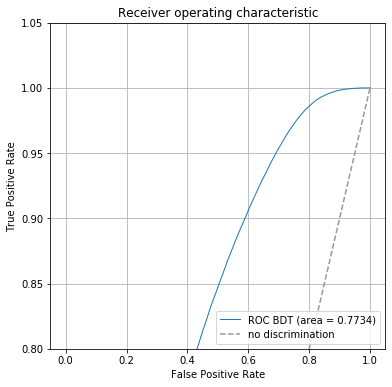

In [289]:
print_roc(model,X_valid, Y_valid )

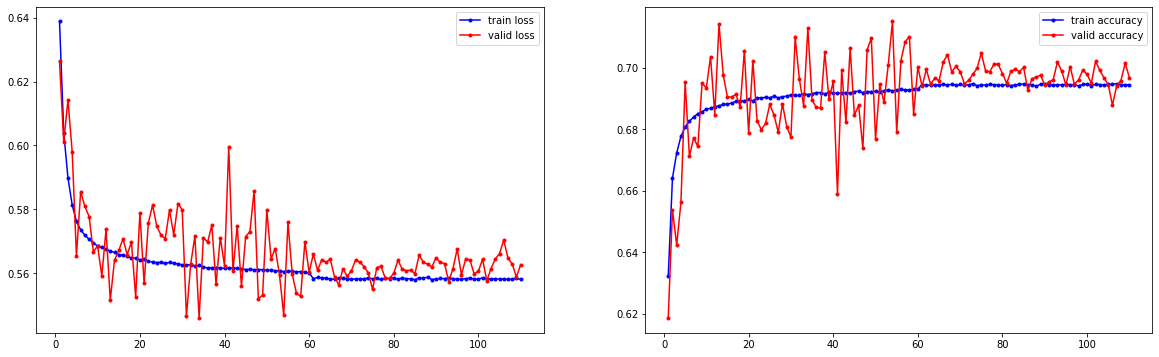

In [290]:
plot_training_classification(run_hist)

In [293]:
model.to(device)

NHiddenTrackingNetwork(
  (input_layer): Linear(in_features=13, out_features=40, bias=True)
  (layers): ModuleList(
    (0): Linear(in_features=40, out_features=30, bias=True)
    (1): Linear(in_features=30, out_features=20, bias=True)
    (2): Linear(in_features=20, out_features=10, bias=True)
  )
  (output_layer): Linear(in_features=10, out_features=2, bias=True)
)

In [294]:
learning_rate = 1e-6
optimizer_3 = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [295]:
model, run_hist = train_and_valid_classification(model, criterion, optimizer_3, run_hist, num_epochs=50)


Epoch 1/50
----------


train loss: 0.5579, train acc: 0.6948, elapsed:152.3418


valid loss: 0.5623, valid acc: 0.6978, elapsed:17.5370

Epoch 2/50
----------


train loss: 0.5582, train acc: 0.6945, elapsed:152.3977


valid loss: 0.5633, valid acc: 0.6966, elapsed:17.6030

Epoch 3/50
----------


train loss: 0.5580, train acc: 0.6949, elapsed:154.8245


valid loss: 0.5626, valid acc: 0.6978, elapsed:17.3710

Epoch 4/50
----------


train loss: 0.5579, train acc: 0.6947, elapsed:156.0382


valid loss: 0.5629, valid acc: 0.6972, elapsed:17.7169

Epoch 5/50
----------


train loss: 0.5581, train acc: 0.6948, elapsed:159.9786


valid loss: 0.5606, valid acc: 0.6995, elapsed:17.7327

Epoch 6/50
----------


KeyboardInterrupt: 

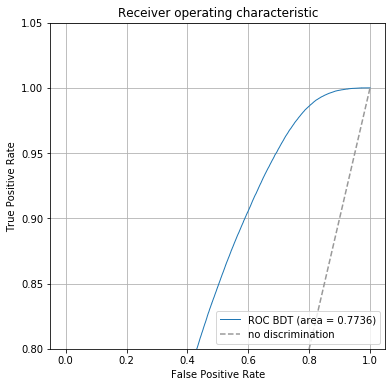

In [296]:
print_roc(model,X_valid, Y_valid )

In [297]:
torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'run_history':run_hist,
            }, ".4NN_3.pt")

In [298]:
def print_classification_report(model, X, Y, threshold =0.2):
    def predict_vs_threshold(probas,threshold):
        predicted = np.where(probas>threshold,1,0)
        return predicted

    
    X = torch.tensor(X.values, dtype=torch.float).to("cpu")
    model.eval
    model.to("cpu")
    output =  model(X)
    probas = F.softmax(output, dim=1)
    print(classification_report(Y, predict_vs_threshold(probas[:,1], threshold), target_names=["ghost","true"]))
    del X



In [302]:
out =  print_classification_report(model,X_valid, Y_valid, 0.23)

              precision    recall  f1-score   support

       ghost       0.98      0.24      0.39   1100498
        true       0.18      0.97      0.30    185790

   micro avg       0.35      0.35      0.35   1286288
   macro avg       0.58      0.61      0.35   1286288
weighted avg       0.87      0.35      0.38   1286288

